# MAST30034_Applied Data Science_Project1

## Import Libraries

In [1]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from geodatasets import get_path
import pandas as pd
import geopandas as gpd
from pyspark.sql.functions import date_format, hour, dayofweek
import seaborn as sns
from scipy.stats import chi2_contingency
from pyspark.sql.functions import count as spark_count
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

In [2]:
# Create a spark session
spark = (
SparkSession.builder.appName("ADS project 1")
.config("spark.sql.repl.eagerEval.enabled", True)
.config("spark.driver.memory","6G")
.config("spark.executor.memory","6G")
.config("spark.sql.parquet.cacheMetadata", "true")
.config("spark.sql.session.timeZone", "Etc/UTC")
.getOrCreate()
)

24/08/22 13:37:34 WARN Utils: Your hostname, chumuhandeMacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 10.13.132.182 instead (on interface en0)
24/08/22 13:37:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/22 13:37:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/22 13:37:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Read Data

In [3]:
taxi_data = spark.read.parquet('../data/data_after_preprocessing/taxi')
citybike_data = spark.read.parquet('../data/data_after_preprocessing/citybike')
weather_data = spark.read.parquet('../data/data_after_preprocessing/weather')

In [4]:
taxi_zones = gpd.read_file("../data/raw/NYCTLC_data/taxi_zone_shipfile/taxi_zones.shp")

In [5]:
taxi_data.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'duration']

In [6]:
citybike_data.columns

['ride_id',
 'rideable_type',
 'started_at',
 'ended_at',
 'start_station_name',
 'start_station_id',
 'end_station_name',
 'end_station_id',
 'start_lat',
 'start_lng',
 'end_lat',
 'end_lng',
 'member_casual',
 'duration']

In [7]:
weather_data.columns

['name',
 'datetime',
 'temp',
 'feelslike',
 'dew',
 'humidity',
 'precip',
 'precipprob',
 'preciptype',
 'snow',
 'snowdepth',
 'windgust',
 'windspeed',
 'winddir',
 'sealevelpressure',
 'cloudcover',
 'visibility',
 'solarradiation',
 'solarenergy',
 'uvindex',
 'severerisk',
 'conditions',
 'icon',
 'stations']

## Research on taxi demand of the map

Draw the map for New York

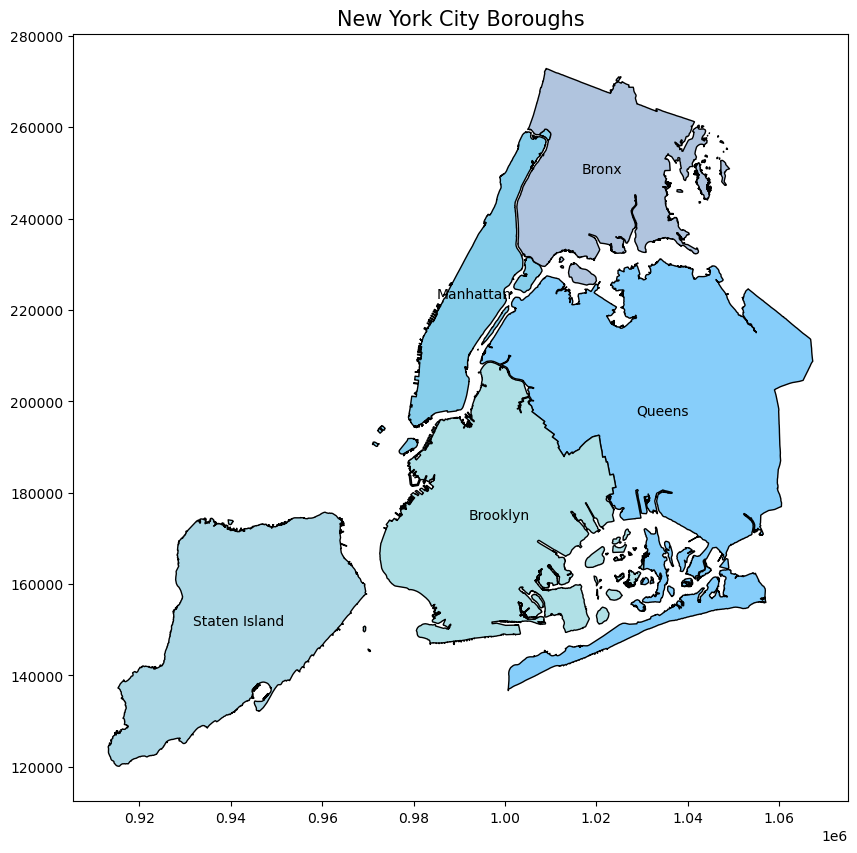

In [8]:
path_to_file = get_path('nybb')
nyc_map = gpd.read_file(path_to_file)
colors = ['#add8e6', '#87cefa', '#b0e0e6', '#87ceeb', '#b0c4de']
fig, ax = plt.subplots(figsize=(10, 10))
nyc_map.plot(ax=ax, color=colors, edgecolor='black')
nyc_map.apply(lambda x: ax.annotate(text=x['BoroName'], xy=x.geometry.centroid.coords[0], ha='center', color='black'), axis=1)
plt.title("New York City Boroughs", fontsize=15)
plt.show()

Draw the taxizone shipfile for New York

<Axes: >

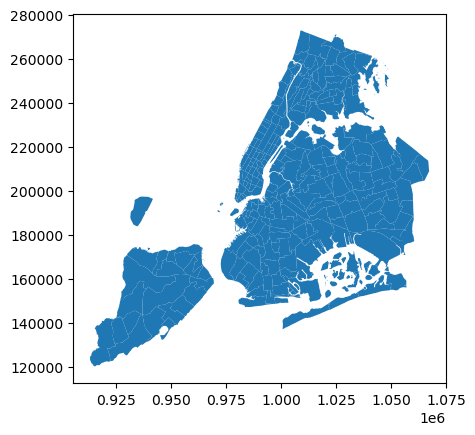

In [9]:
taxi_zones.plot()

Taxi boarding counted by zone

<Figure size 1200x800 with 0 Axes>

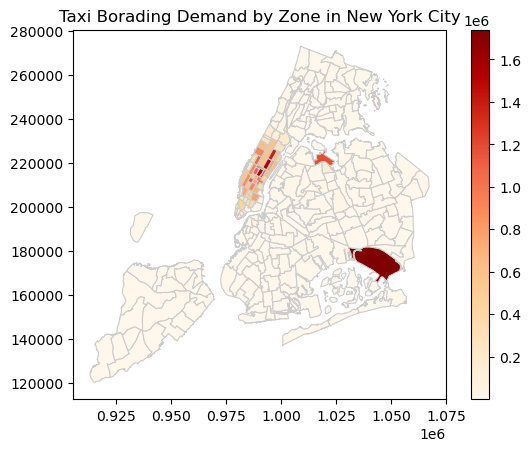

In [10]:
# Count the number of passengers in each zone of NewYork
demand_data_PUL = taxi_data.groupBy("PULocationID").count()
demand_data_PUL = demand_data_PUL.withColumnRenamed("count", "demand")
pandas_demand_data_PUL = demand_data_PUL.toPandas()

# Combine the zone data with the taxi demand data
taxi_zones_merge_PUL = taxi_zones.merge(pandas_demand_data_PUL, how='left', left_on='LocationID', right_on='PULocationID')

# Drawing an image
plt.figure(figsize=(12, 8))
taxi_zones_merge_PUL.plot(column='demand', cmap='OrRd', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Taxi Borading Demand by Zone in New York City')
plt.show()

In [11]:
# Write the top 10 zone
top_10_zones_PUL = taxi_zones_merge_PUL.nlargest(10, 'demand')[['zone', 'demand']]
top_10_zones_PUL

,zone,demand
131,JFK Airport,1739961.0
236,Upper East Side South,1561016.0
160,Midtown Center,1546733.0
235,Upper East Side North,1374460.0
161,Midtown East,1190014.0
137,LaGuardia Airport,1176993.0
185,Penn Station/Madison Sq West,1140755.0
229,Times Sq/Theatre District,1103716.0
141,Lincoln Square East,1086038.0
169,Murray Hill,982015.0


Taxi drop-off zone count

<Figure size 1200x800 with 0 Axes>

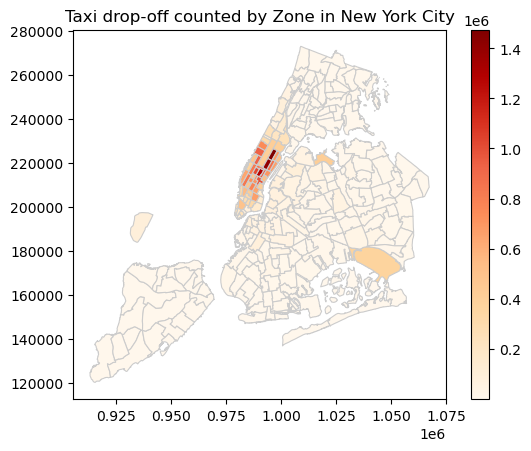

In [12]:
# Count the number of passengers in each zone of NewYork
demand_data_DOL = taxi_data.groupBy("DOLocationID").count()
demand_data_DOL = demand_data_DOL.withColumnRenamed("count", "demand")
pandas_demand_data_DOL = demand_data_DOL.toPandas()

# Combine the zone data with the taxi drop-off counted data
taxi_zones_merge_DOL = taxi_zones.merge(pandas_demand_data_DOL, how='left', left_on='LocationID', right_on='DOLocationID')

# Drawing an image
plt.figure(figsize=(12, 8))
taxi_zones_merge_DOL.plot(column='demand', cmap='OrRd', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Taxi drop-off counted by Zone in New York City')
plt.show()

In [13]:
# Write the top 10 zone
top_10_zones_DOL = taxi_zones_merge_DOL.nlargest(10, 'demand')[['zone', 'demand']]
top_10_zones_DOL

,zone,demand
235,Upper East Side North,1474705.0
236,Upper East Side South,1403785.0
160,Midtown Center,1288504.0
229,Times Sq/Theatre District,1020782.0
169,Murray Hill,979375.0
161,Midtown East,944835.0
141,Lincoln Square East,929446.0
238,Upper West Side South,928825.0
140,Lenox Hill West,873115.0
67,East Chelsea,835169.0


## The Top 10 start station of citi Bike

In [14]:
# Count the stations with the highest number of bike 
def plot_top_stations(citybike_data, feature_name):
    start_stations_count = citybike_data.groupBy(feature_name).count().orderBy(F.desc("count")).limit(10)
    start_stations_count = start_stations_count.toPandas()
    # Draw a bar chart
    plt.figure(figsize=(20, 8))
    plt.bar(start_stations_count[feature_name], start_stations_count['count'], color='lightblue', width=0.6)
    for i in range(len(start_stations_count)):
        plt.text(i, start_stations_count['count'][i] + 100, f"{start_stations_count['count'][i]}",
                 ha='center', fontsize=15)
    plt.title(f"Top 10 {feature_name} in NewYork", fontsize=30)
    plt.xlabel("Station Name", fontsize=20)
    plt.ylabel("Count", fontsize=20)
    plt.xticks(rotation=20, ha="right", fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

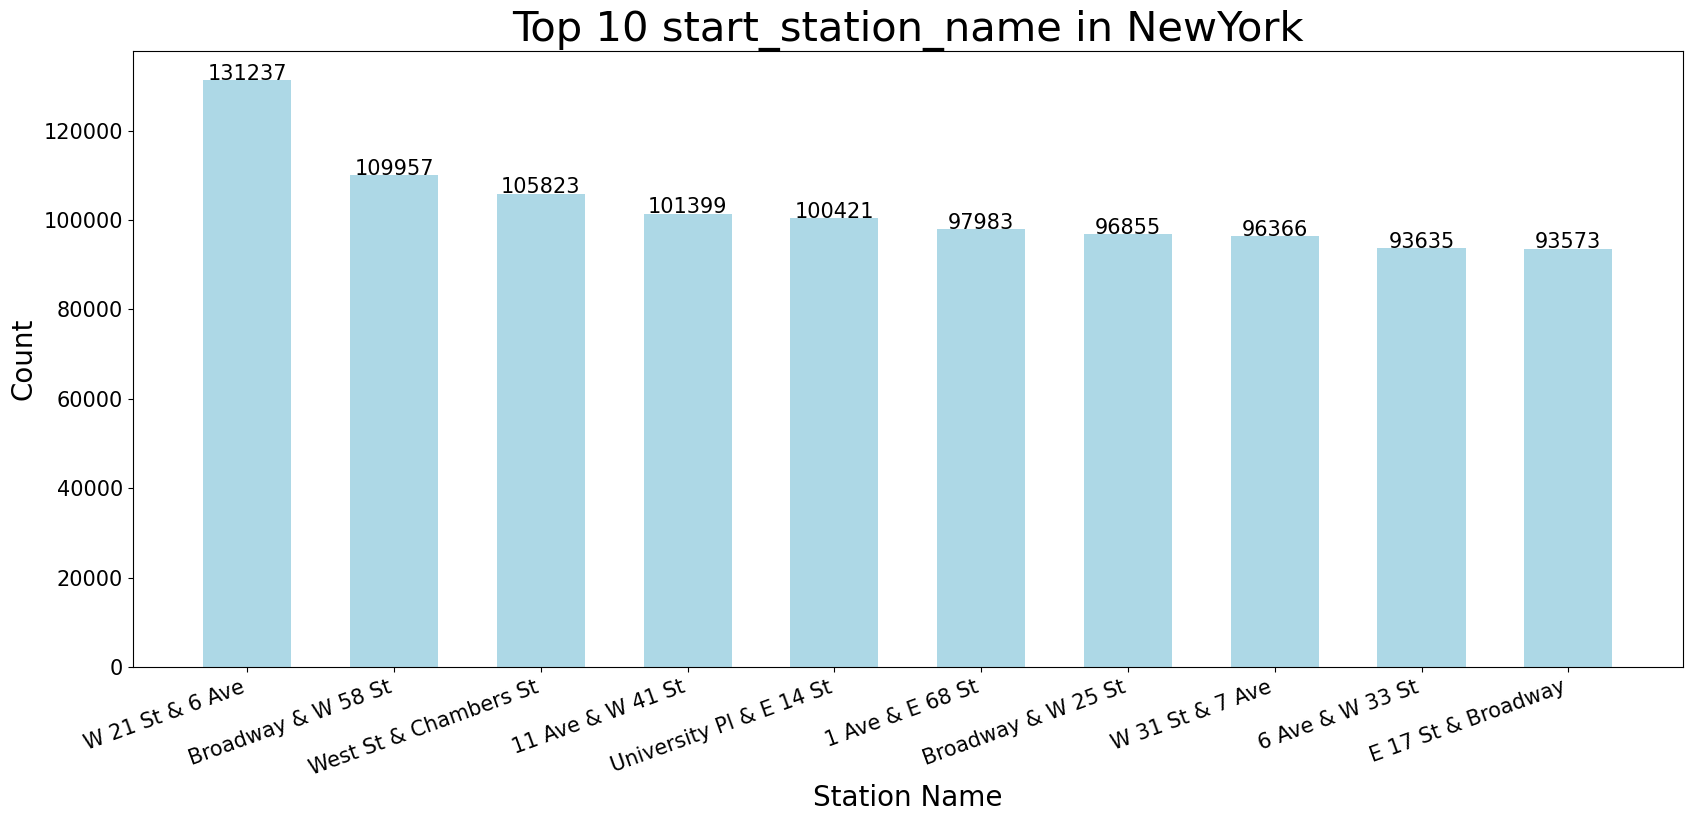

In [15]:
plot_top_stations(citybike_data, feature_name ='start_station_name')

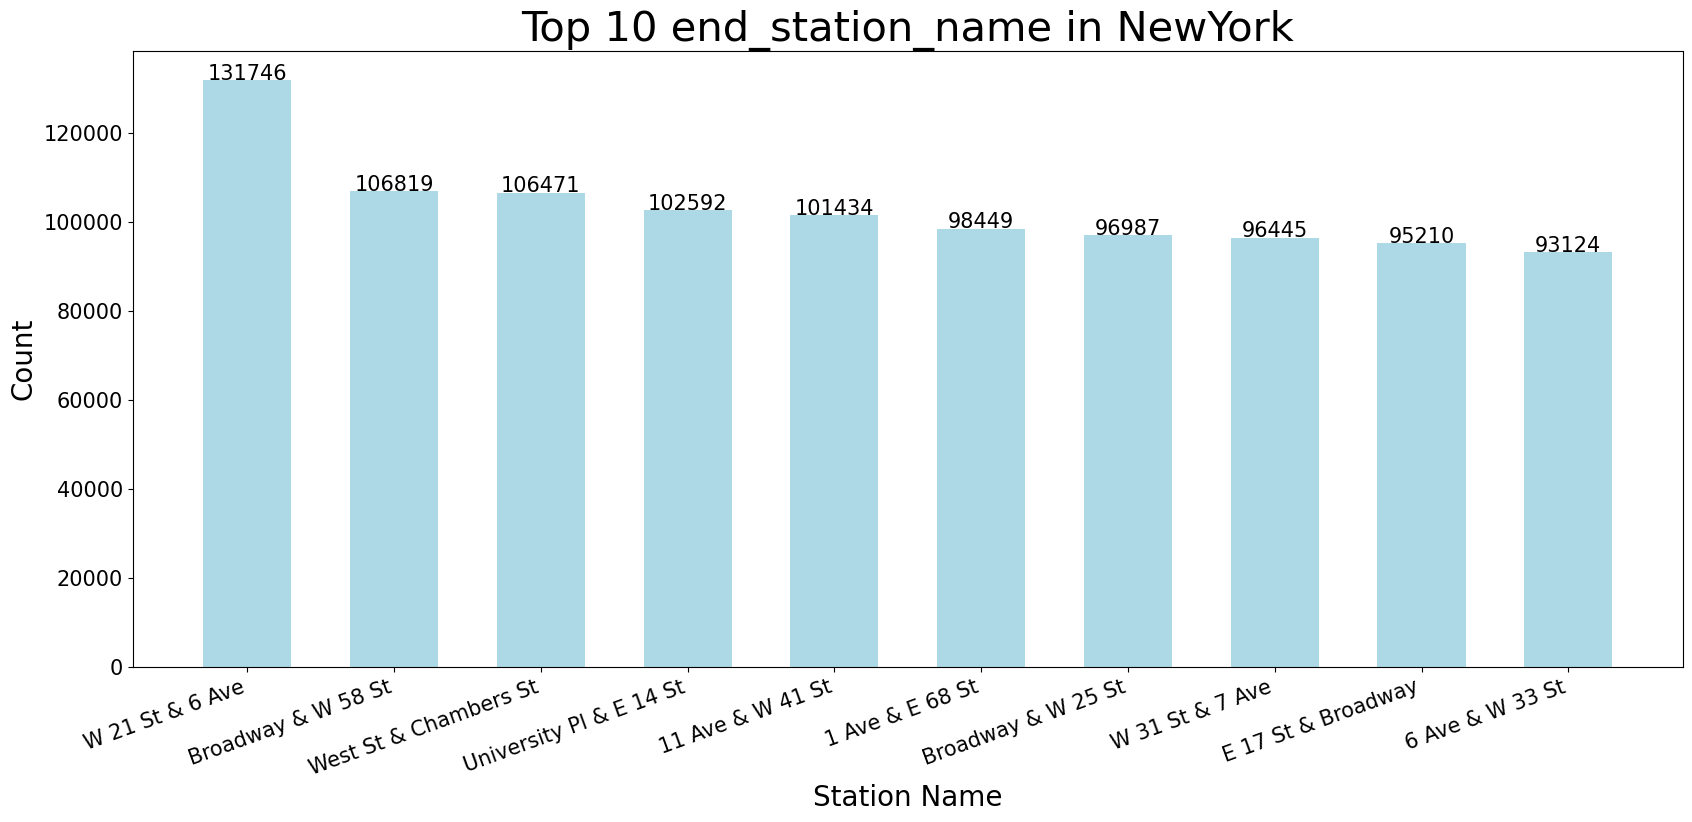

In [16]:
plot_top_stations(citybike_data, feature_name ='end_station_name')